# 【第一回目　課題２】フレームワークを使わない深層学習 (2): 畳み込み編

次は，フレームワークを使わないで畳み込み層を実装してみます．順伝搬でim2col, 逆伝搬でcol2imを使えば，基本は全結合と同じである，という点がポイントです．im2col, col2imを使わずに実装するのはかなり複雑で，単純に実装すると6重ループになりますので，通常のフレームワークではim2col, col2imで計算するのが一般的です．

順伝搬は，im2col によって，feature mapをim2col表現に展開します．そうすると，畳み込みは フィルタ行列とim2col行列の行列積として表現できます．
つまり，im2col + 全結合層　と等価になります．

逆伝搬は，逆をたどれば良いので，全結合の逆伝搬 + im2col表現のfeature mapへの逆変換 (col2im変換)となります．

まとめると，im2col, col2imの変換ができれば，あとは全結合の順伝搬計算，逆伝搬計算がそのまま利用できます．

では，im2col, col2im を実装してみましょう．


In [1]:
# 以下の２行はJupyter環境の場合のみ必要
%matplotlib inline
from IPython import display
import math
import numpy as np
import matplotlib.pyplot as plt

さあ，Convクラスを実装します．課題1のFCクラスを継承してもいいですが，コードを再利用して，独立に実装してみます．
__call__(), backfard() に加えて，im2col, col2im関数を追加します．

順伝搬は，最初にim2colの呼び出し，次にFcと同じ行列の積和演算，最後に追加で，
(n_filter,out_h$\times$out_w) のサイズの出力を (n_filter,out_h,out_w) にreshapeして，3次元のfeature mapに変形して出力します．

逆伝搬は，最初に(n_filter,out_h,out_w)のfeature mapに関する勾配を　(n_filter,out_h$\times$out_w) の行列に変換して，
Fcの時と同じ逆伝搬計算を行います．最後に，dEdyに関して，col2im変換を行って，3次元のfeature mapに変形して出力します．

In [2]:
class Conv:
    def __init__(self,c,h,w,n_filter,pad=0,stride=1,relu=True, seed=0):
        self.filter = (c,w,h)
        self.filter_c = c; self.filter_h=h; self.filter_w=w
        self.n_filter = n_filter
        self.pad = pad
        self.stride = stride
        self.relu= relu
        n_in = c * w * h
        self.n_in = n_in
        n_out = n_filter
        # 学習パラメータは, 重み行列w(=フィルタ), バイアス項b
        # サイズは以下の通り
        self.size_w = (n_out,n_in)
        self.size_b = (n_out,1)
        # w,b は全結合層の学習パラメータ．
        # ReLuも全結合の中にいれてある．
        # ReLU=Trueのときは，Heの初期値．Falseのときは，Xavierの初期値とする．
        # xは直前のforward計算時の入力値．BPの計算時に必要． 
        np.random.seed(seed) # 同じ初期値を再現できるように seed を指定します．
        if relu:
            self.w = np.random.normal(0, math.sqrt(2.0/n_in), self.size_w) # Heの初期値
            self.relu0 = None # ReLUの順伝搬時に０以下で値が伝搬されない要素のインデックスを記録．BP時に利用．
        else:
            self.w = np.random.normal(0, math.sqrt(1.0/n_in), self.size_w) # Xavierの初期値   
        self.b = np.zeros((n_out,1))
        self.x = np.zeros((n_in,1))
        # 誤差逆伝搬(Back-Propagation時の勾配を記録する変数)
        self.dEdx = np.zeros((n_in,1)) # dE/dx を表す　BPの時に直前レイヤに伝わる勾配でδと表現されます．
        self.dEdw = np.zeros((n_out,n_in)) # dE/dw を表す
        self.dEdb = np.zeros((n_out,1)) # dE/db を表す
        self.count = 0
        # 以下，MomentamSDGのための設定
        self.mdw = np.zeros((n_out,n_in))
        self.mdb = np.zeros((n_out,1))
    
    # forward は __call__ を使って定義する．im2col + 行列積和．
    def __call__(self,input_):   # 入力はfeature map
        x,out_h,out_w = self.im2col(input_) # x のサイズは (self.n_in, out_h*out_w)
        self.x = x
        #self.size_input=input.shape
        #self.size_output=(self.n_filter,out_h,out_w)
        self.out_h = out_h
        self.out_w = out_w
        # w のサイズは，(n_filter, n_in), よって y のサイズは (n_filter,out_h*out_w)
        self.y = np.dot(self.w, x) + self.b
        # ReLUは，値が０以下の要素は，０とする．０とした要素のインデックスは relu0に記録し，BP時に勾配を伝搬させない．
        if self.relu:
            self.relu0= self.y<=0
            self.y[self.relu0] = 0
        # 最後に，(n_filter,out_h,out_w) にreshape
        return np.reshape(self.y,(self.n_filter,out_h,out_w))

    # backward は，dE/dy を受け取って，dE/dx を出力．内部では，dE/dw, dE/db を更新
    def backward(self, dEdy0):
        dEdy = np.reshape(dEdy0,(self.n_filter,self.out_h*self.out_w))
        # 順伝搬時に値が０以下だった要素は勾配を０として，勾配伝搬しない．
        if self.relu:
            dEdy[self.relu0] = 0
        dydx = np.transpose(self.w)  # dWx/dx= np.transpose(W) であることより．
        dydw = np.transpose(self.x)  # dWx/dW= np.transpose(x) 
        # dydb = np.ones((self.n_out,1))   #  db/db = np.ones((n_out,1))　１なので特に計算しない．
        # dEdw, dEdb に勾配を加算．dEdx (δ)は前層へ伝搬する勾配で，backwardの返り値とする．
        self.dEdx = np.dot(dydx, dEdy)
        self.dEdw += np.dot(dEdy, dydw)
        self.dEdb += np.c_[np.sum(dEdy, axis=1)]  # channelごとにfeature map 全体が1つのバイアスに対応するので channelごとにsumします．
        # 勾配の平均を取るために，足した勾配のサンプル数を記録．
        # conv の場合は，フィルタを適用した回数．つまり，出力feature mapの画素数
        self.count += (self.out_h*self.out_w)  
        # 最後に，col2imでfeature mapに対応するδを求める
        out=self.col2im(self.dEdx)
        return out

    # im2col は，feature map を　縦が1回の畳み込みに必要な局所画像サイズ(filter_c*filter_h*filter_w)，
    # 横が(out_h*out_w) になる行列に変換する関数 
    def im2col(self,input_):
        c, h, w = input_.shape
        out_h = (h + 2*self.pad - self.filter_h)//self.stride + 1
        out_w = (w + 2*self.pad - self.filter_w)//self.stride + 1
        # padding 分をzero paddingで追加したimを生成
        im = np.pad(input_, [(0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        # filterの各x,yの位置ごとに，対応するfeature mapの値を格納し，
        # 最後に transpose -> reshape で，im2col出力行列を生成
        col = np.zeros((c, self.filter_h, self.filter_w, out_h, out_w))
    
        for y in range(self.filter_h):
            y_max = y + self.stride*out_h
            for x in range(self.filter_w):
                x_max = x + self.stride*out_w
                # filterの位置に応じてずらしてfeature mapをコピー
                # stride>1の時は飛ばしてfeature mapをコピー
                col[:, y, x, :, :] = im[:, y:y_max:self.stride, x:x_max:self.stride]
        # チャネル軸を1番目から3番目に移動して，reshapeして，(filter_c,out_h*out_w)とする
        col = col.transpose(1, 2, 0, 3, 4).reshape((self.n_in, out_h*out_w))
        return col,out_h,out_w

    # col2im は，im2col形式の勾配δをfeature map形式に変換する．逆伝搬で使用．
    def col2im(self,col):
        col_h, col_w = col.shape # (filter_c*filter_h*filter_w, out_h*out_w)
        h = (self.out_h-1)*self.stride + self.filter_h
        w = (self.out_w-1)*self.stride + self.filter_w
        c = self.filter_c
    
        # サイズ(x,h,w)の im 行列を0で初期化
        im = np.zeros((c,h,w))
        # feature map colの各場所について，勾配を対応するimの場所に加算する
        for j in range(self.out_h):
            for i in range(self.out_w):
                im[:, j:j+self.filter_h, i:i+self.filter_w] += np.reshape(col[:, j * self.out_w + i],(c,self.filter_h,self.filter_w))
        return im[:,self.pad:h-self.pad,self.pad:w-self.pad]        

    # 以下は，updater で，Fcと同じ実装です．ちゃんと実装するなら，super classにする方がいいでしょう．
    # 勾配をクリア
    def clear_grad(self):
        self.dEdw = 0
        self.dEdb = 0
        self.count = 0

    # 勾配法で重みをアップデート．countで割って，足しこんだ勾配のサンプル数で平均を取る
    def update(self, lr=0.001):
        self.w -= self.dEdw/self.count * lr
        self.b -= self.dEdb/self.count * lr
        self.clear_grad()
    
    # 慣性項（モーメンタム項）付きの勾配法 課題1の5
    def updatem(self, lr=0.001, mu=0.9):
        self.mdw = mu * self.mdw - (self.dEdw/self.count) * lr
        self.mdb = mu * self.mdb - (self.dEdb/self.count) * lr
        self.w += self.mdw
        self.b += self.mdb
        self.clear_grad()
    
    # adagrad (課題2 任意発展課題の2)
    def update_adagrad(self, lr=0.001):
        self.h += (self.dEdw/self.count)**2
        self.w -= lr * (self.dEdw/self.count)/(np.sqrt(self.h + 1e-7))
        self.b -= lr * (self.dEdb/self.count)/(np.sqrt(self.h + 1e-7))
        self.clear_grad()
        
    def update_adam(self, lr =0.001, beta1=0.9, beta2=0.99):
        self.mw = beta1 * self.m - (1-beta1) * (self.dEdw/self.count)
        self.vw = beta2 * self.v - (1-beta1) * (self.dEdw/self.count)**2
        
        self.mb = beta1 * self.m - (1-beta1) * (self.dEdb/self.count)
        self.vb = beta2 * self.v - (1-beta1) * (self.dEdb/self.count)**2
        
        mhat_w = self.mw / (1- beta1**count)
        vhat_w = self.vw / (1- beta2**count)
        
        mhat_b = self.mb / (1- beta1**count)
        vhat_b = self.vb / (1- beta2**count)
        
        self.w -= lr * mhat_w/(np.sqrt(vhat_w) + 1e-7)
        self.b -= lr * mhat_b/(np.sqrt(vhat_b) + 1e-7)
        
        self.clear_grad()

では，ここでは，簡単な問題として，グレーススケール化とエッジ検出のフィルタを3層の畳み込みネットワークで学習してみましょう．

とりあえず，画像1枚だけで学習します．畳み込みはフィルタをスライドさせて演算しますので，スライドさせる分だけ別々のデータで学習を行っているのと等価になります．例えば，3x3のフィルタを320x240の画像で学習すれば，320x240通りでスライドできますので，Fc層での学習を76800回行ったのと等価になります．

In [3]:
from skimage import feature,filters
from PIL import Image
import os
import sys

In [4]:
img_org = Image.open('../figure/uec.jpg').resize((320,240))
img = np.array(img_org, dtype=np.uint8)
grey = np.array(img_org.convert('L'), dtype=np.uint8)
edge = feature.canny(grey,sigma=2)  # Canny でエッジ抽出
# edge = filters.sobel(grey) # Sobel でエッジ抽出
edge = edge * 255

読み込んだ画像と変換した画像を，numpy形式に変換します．
(c,h,w) c:チャネル, h:高さ, w:幅　のサイズの3次元配列にします．
ここでは画像は320x240で，入力はカラーなので，
input: (3,240,320)
output: (1,240,320)
の大きさです．

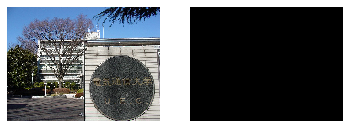

In [5]:
# エッジ検出フィルタ，グレースケール化フィルタの切り替え
use_edge = True  # Falseだとグレースケール化フィルタの学習
if use_edge:
    gt = edge
else:
    gt = grey
    

plt.subplot(121)
plt.axis("off")
plt.imshow(img)
plt.subplot(122)
plt.axis("off")
plt.imshow(gt,cmap="gray")

# 画素値が [-1,1) の範囲の値になるように変換
input_  = (np.asarray(img, dtype=np.float32).transpose(2,0,1)-128)/128.0
output = (np.expand_dims(np.asarray(gt, dtype=np.float32),0)-128)/128.0

畳み込み層を3つ用意します．
3x3x10 -> 3x3x10 -> 3x3x1 です．
1,2層目はReLU付きです．

In [6]:
c1 = Conv(3,3,3,10,pad=1)
c2 = Conv(10,3,3,10,pad=1)
c3 = Conv(10,3,3,1,pad=1,relu=0)

学習ループです．
学習率lr = 0.01
エポック数200とします．


In [7]:
def show_learning_result(c1, c2, c3, lr=0.1, mu=0.9, beta1=0.9, beta2=0.99, num_epoch=200, optimizer="sgd"):
    """
    fc1: 畳み込み層の1層目
    fc2: 畳み込み層の2層目
    fc3:畳み込み層の3層目
    learning_rate(float): 学習率
    mu(float): 慣性項の係数 momentum_sgdで使用
    beta1(float): adamで利用するパラメータ
    beta2(float): adamで利用するパラメータ
    num_epoch(int): エポック数
    optimizer(list): 勾配の最適化方法 ["sgd", "momentum_sgd", "adam", "adagrad"]という文字列を代入することを想定
    """
    lr = lr
    num_epoch = num_epoch
    losses = np.array([])
    ep = np.array([])

    # 表示エリアの設定
    fig = plt.figure()
    fig1 = fig.add_subplot(121)
    fig2 = fig.add_subplot(122)

    for epoch in range(num_epoch):
        if epoch > 0 and epoch %100 ==0:
            lr *= 0.1
        # 順伝搬計算
        y = c3(c2(c1(input_)))
        # 誤差微分値，誤差値を計算します． 
        dEdx = y - output
        loss = np.sum(dEdx**2)*0.5/(y.shape[1] * y.shape[2])
        # print("epoch: {} loss: {} lr: {}".format(epoch, loss,lr))
        # dEdx (δ)を計算して，逆伝搬します．
        dEdx = c3.backward(dEdx)
        dEdx = c2.backward(dEdx)
        dEdx = c1.backward(dEdx)
        # 順伝搬，逆伝搬を行ったら，SDGで重みを更新
        # out_h*out_w 分の順伝搬の勾配がすべて合計されていますので，
        # batchsize 1 でも，実質batchisizeは out_h*out_w (例えば，320*240だと76800)になります．
        if optimizer == "sgd":
            c1.update(lr)
            c2.update(lr)
            c3.update(lr)
        elif optimizer == "momentum_sgd":
            c1.updatem(lr, mu)
            c2.updatem(lr, mu)
            c3.updatem(lr, mu)
        elif optimizer == "adam":
            c1.update_adam(lr, beta1, beta2)
            c2.update_adam(lr, beta1, beta2)
            c3.update_adam(lr, beta1, beta2)
        elif optimizer == "adagrad":
            c1.update_adagrad(lr)
            c2.update_adagrad(lr)
            c3.update_adagrad(lr)

        losses = np.append(losses,loss)
        ep = np.append(ep,epoch)
        if epoch%10 == 0:
            display.clear_output(wait = True)
            fig1.axis([0, num_epoch, 0, 0.5])
            fig1.plot(ep,losses,"r")
            out = (y.squeeze()+1.0)*128.0 # 表示するときは，[0.256)に戻します．
            fig2.axis("off")
            fig2.imshow(out,cmap="gray",vmin=0,vmax=255)
            display.display(fig)
            if epoch < num_epoch-1:
                fig2.cla()

    display.clear_output(wait = True)
    fig1.plot(ep,losses,"r")
    fig2.imshow(out,cmap="gray",vmin=0,vmax=255)
    print("loss: {}".format(loss))

loss: 0.002818659418378944


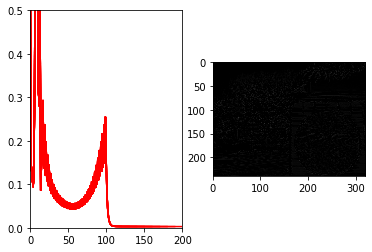

In [8]:
show_learning_result(c1, c2, c3)

### 課題2
以下の小問の(1)-(5)を解答せよ．

1. 上記のコードにおける畳込み層の順伝搬，逆伝搬の計算方法を説明せよ．さらに，自分で用意した画像に対して，上記のコードを実行せよ．
1. モデルパラメータ（例えば，10->20) を変化させて，結果を比較せよ．(特に最終loss値)
1. 学習率を変化させて挙動を観察せよ．
1. 1,2層にReLUを入れた場合と，3層ともReLUなしの場合の結果を比較せよ．
1. モーメンタムSDGに変更して，ノーマルなSDGとの違いを観察せよ．

### 【課題2: 任意発展課題】
興味のある人は，例えば，以下のような拡張を行ってみよ．

1. 複数枚の学習画像(2～10枚程度)に対応させて，lossの下がり方の違いについて観察せよ．random shuffleは入れても入れなくてもよい．
1. Adam, AdaGrad のどちらか一方，もしくは両方を実装して比較せよ．
1. 最終層の活性化関数に tanhを利用せよ．
1. Batch Normalization Layerを追加せよ．
1. Max pooling layerを実装せよ．Average Pooling も実装するとなお良い．
1. 上記のmini-batch対応を行った後，cupy ライブラリを使って，GPUに対応させよ．
1. SoftMax関数を追加し，Max Pooling, Fcクラスと組み合わせて，MNISTやCIFAR-10のサブセットなど，分類タスクを行ってみよ．(minibatch単位の計算+cupyの利用がないとおそらく厳しい．)